# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

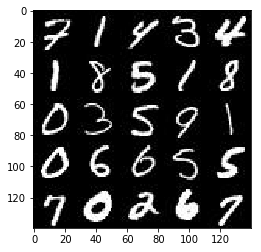

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

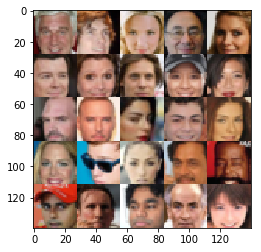

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels (or colors)
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    # placeholder for input to Discriminator
    inputs_images = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels), name='Real_Input') 
    # placeholder for input to Generator
    inputs_z_data = tf.placeholder(tf.float32, shape=(None, z_dim), name='Z_Input')
    learning_rate = tf.placeholder(tf.float32, shape=(None), name='Learning_Rate')
    return inputs_images, inputs_z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
filter_size = 7
layer_depth = 256

def discriminator(images, reuse=False, alpha=0.01):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :param alpha: numeric value used to configure Leaky RELU
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x = tf.layers.conv2d(images, 64, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.maximum(x, x*alpha)
        # 16x16x64
        
        x = tf.layers.conv2d(x, 128, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, x*alpha)
        # 8x8x128

        x = tf.layers.conv2d(x, 256, 5, strides=2, padding='same',kernel_initializer=tf.contrib.layers.xavier_initializer())
        x = tf.layers.batch_normalization(x, training=True)
        x = tf.maximum(x, x*alpha)
        # 4x4x256

        flat = tf.reshape(x, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        #out = tf.nn.dropout(out, keep_prob=0.99)
    return out, logits

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True, alpha=0.01):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        # First fully connected layer converted into deep layer
        x = tf.layers.dense(z, filter_size*filter_size*layer_depth)
        # Layer 1 - convolution
        x = tf.reshape(x, (-1,filter_size,filter_size,layer_depth))
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, x * alpha) # leaky RELU
        # x is of the following shape:  filter_size x filter_size x layer_depth (e.g. 4 x 4 x 1024)
        
        # Layer 2 - convolution 
        x = tf.layers.conv2d_transpose(x, int(layer_depth/2), 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, x * alpha) # leaky RELU
        # x is of the following shape:  2*filter_size x 2*filter_size x layer_depth/2 (e.g. 8 x 8 x 512)
        
        # Layer 3 - convolution
        x = tf.layers.conv2d_transpose(x, int(layer_depth/4), 5, strides=2, padding='same')
        x = tf.layers.batch_normalization(x, training=is_train)
        x = tf.maximum(x, x * alpha) # leaky RELU   
        # x is of the following shape:  4*filter_size x 4*filter_size x layer_depth/4 (e.g. 16 x 16 x 256)
        
        # Logits
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides=1, padding='same')
        # out_channel_dim, e.g. 28x28x3 now
        out = tf.tanh(logits)
        return out

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.01):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()      
        self.input_real, self.input_z, self.learningrate = model_inputs(real_size[0], real_size[1], real_size[2], z_size)
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z, real_size[2], alpha=alpha)
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)
        
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, alpha=0.01):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    net = GAN(data_shape[1:], z_dim, learning_rate, alpha=alpha, beta1=beta1)
    
    print_every=20
    show_every=200

    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                x = batch_images * 2

                if steps == 1:
                # let's display the first set of images
                    show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)

                # optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})
                                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Step {}...".format(steps),
                          "Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                if steps % show_every == 0:
                    show_generator_output(sess, 25, net.input_z, data_shape[3], data_image_mode)


### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Number of images & shape of images:
(60000, 28, 28, 1)


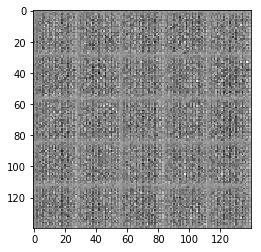

Step 20... Epoch 1/1... Discriminator Loss: 0.0151... Generator Loss: 6.3209
Step 40... Epoch 1/1... Discriminator Loss: 0.7277... Generator Loss: 2.2335
Step 60... Epoch 1/1... Discriminator Loss: 0.2338... Generator Loss: 2.5413
Step 80... Epoch 1/1... Discriminator Loss: 0.4735... Generator Loss: 2.2684
Step 100... Epoch 1/1... Discriminator Loss: 2.3259... Generator Loss: 0.1885
Step 120... Epoch 1/1... Discriminator Loss: 2.2460... Generator Loss: 0.1582
Step 140... Epoch 1/1... Discriminator Loss: 2.4406... Generator Loss: 0.1921
Step 160... Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.3681
Step 180... Epoch 1/1... Discriminator Loss: 1.5131... Generator Loss: 0.3875
Step 200... Epoch 1/1... Discriminator Loss: 1.1999... Generator Loss: 1.0245


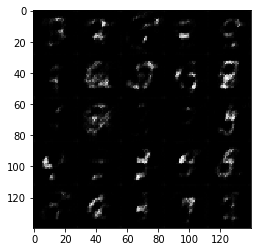

Step 220... Epoch 1/1... Discriminator Loss: 1.2155... Generator Loss: 0.5561
Step 240... Epoch 1/1... Discriminator Loss: 1.7492... Generator Loss: 0.2926
Step 260... Epoch 1/1... Discriminator Loss: 2.5325... Generator Loss: 0.0957
Step 280... Epoch 1/1... Discriminator Loss: 1.5625... Generator Loss: 0.5525
Step 300... Epoch 1/1... Discriminator Loss: 2.3949... Generator Loss: 0.1217
Step 320... Epoch 1/1... Discriminator Loss: 1.4145... Generator Loss: 0.4191
Step 340... Epoch 1/1... Discriminator Loss: 1.1253... Generator Loss: 0.6862
Step 360... Epoch 1/1... Discriminator Loss: 1.0660... Generator Loss: 1.0534
Step 380... Epoch 1/1... Discriminator Loss: 2.1086... Generator Loss: 0.2407
Step 400... Epoch 1/1... Discriminator Loss: 1.5761... Generator Loss: 0.3028


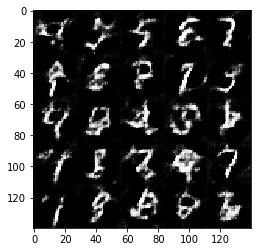

Step 420... Epoch 1/1... Discriminator Loss: 1.6662... Generator Loss: 0.3263
Step 440... Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.8753
Step 460... Epoch 1/1... Discriminator Loss: 1.2987... Generator Loss: 0.6456
Step 480... Epoch 1/1... Discriminator Loss: 1.2750... Generator Loss: 0.6841
Step 500... Epoch 1/1... Discriminator Loss: 1.4719... Generator Loss: 0.4132
Step 520... Epoch 1/1... Discriminator Loss: 1.9524... Generator Loss: 0.2497
Step 540... Epoch 1/1... Discriminator Loss: 1.1379... Generator Loss: 0.8079
Step 560... Epoch 1/1... Discriminator Loss: 1.4308... Generator Loss: 0.3987
Step 580... Epoch 1/1... Discriminator Loss: 1.3410... Generator Loss: 0.4123
Step 600... Epoch 1/1... Discriminator Loss: 1.0182... Generator Loss: 0.7594


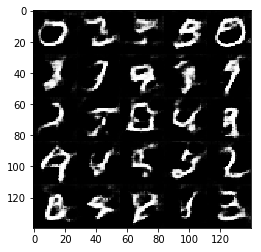

Step 620... Epoch 1/1... Discriminator Loss: 1.4676... Generator Loss: 0.4363
Step 640... Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.4258
Step 660... Epoch 1/1... Discriminator Loss: 1.5056... Generator Loss: 0.3291
Step 680... Epoch 1/1... Discriminator Loss: 1.5171... Generator Loss: 0.3532
Step 700... Epoch 1/1... Discriminator Loss: 1.0371... Generator Loss: 0.8026
Step 720... Epoch 1/1... Discriminator Loss: 2.4099... Generator Loss: 0.1132
Step 740... Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.6763
Step 760... Epoch 1/1... Discriminator Loss: 0.9316... Generator Loss: 0.9940
Step 780... Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 0.9702
Step 800... Epoch 1/1... Discriminator Loss: 0.9863... Generator Loss: 0.6981


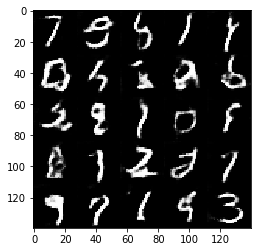

Step 820... Epoch 1/1... Discriminator Loss: 0.7577... Generator Loss: 0.9200
Step 840... Epoch 1/1... Discriminator Loss: 0.7777... Generator Loss: 0.8667
Step 860... Epoch 1/1... Discriminator Loss: 1.0828... Generator Loss: 0.5366
Step 880... Epoch 1/1... Discriminator Loss: 1.2353... Generator Loss: 0.4662
Step 900... Epoch 1/1... Discriminator Loss: 0.7007... Generator Loss: 1.4122
Step 920... Epoch 1/1... Discriminator Loss: 1.5236... Generator Loss: 0.4775
Step 940... Epoch 1/1... Discriminator Loss: 1.1913... Generator Loss: 0.7989
Step 960... Epoch 1/1... Discriminator Loss: 1.4674... Generator Loss: 0.6251
Step 980... Epoch 1/1... Discriminator Loss: 1.1828... Generator Loss: 0.6070
Step 1000... Epoch 1/1... Discriminator Loss: 0.7329... Generator Loss: 0.8586


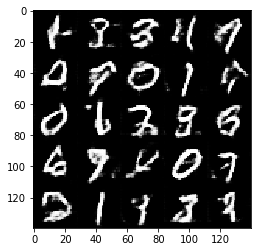

Step 1020... Epoch 1/1... Discriminator Loss: 0.9323... Generator Loss: 0.8539
Step 1040... Epoch 1/1... Discriminator Loss: 0.9575... Generator Loss: 0.8680
Step 1060... Epoch 1/1... Discriminator Loss: 1.2520... Generator Loss: 0.4697
Step 1080... Epoch 1/1... Discriminator Loss: 2.6410... Generator Loss: 0.0951
Step 1100... Epoch 1/1... Discriminator Loss: 1.4950... Generator Loss: 0.3408
Step 1120... Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.5305
Step 1140... Epoch 1/1... Discriminator Loss: 0.7533... Generator Loss: 0.8514
Step 1160... Epoch 1/1... Discriminator Loss: 0.7803... Generator Loss: 1.3867
Step 1180... Epoch 1/1... Discriminator Loss: 0.9348... Generator Loss: 0.9349
Step 1200... Epoch 1/1... Discriminator Loss: 0.9793... Generator Loss: 0.8934


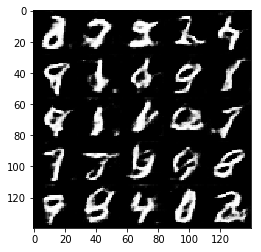

Step 1220... Epoch 1/1... Discriminator Loss: 1.2299... Generator Loss: 0.5926
Step 1240... Epoch 1/1... Discriminator Loss: 0.7293... Generator Loss: 0.9410
Step 1260... Epoch 1/1... Discriminator Loss: 1.0137... Generator Loss: 0.6524
Step 1280... Epoch 1/1... Discriminator Loss: 0.6255... Generator Loss: 2.0423
Step 1300... Epoch 1/1... Discriminator Loss: 1.1343... Generator Loss: 0.5789
Step 1320... Epoch 1/1... Discriminator Loss: 0.5297... Generator Loss: 1.7347
Step 1340... Epoch 1/1... Discriminator Loss: 0.7669... Generator Loss: 1.1139
Step 1360... Epoch 1/1... Discriminator Loss: 1.5672... Generator Loss: 0.3690
Step 1380... Epoch 1/1... Discriminator Loss: 0.9587... Generator Loss: 0.7514
Step 1400... Epoch 1/1... Discriminator Loss: 0.9884... Generator Loss: 1.0138


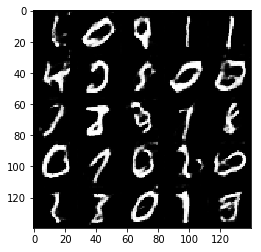

Step 1420... Epoch 1/1... Discriminator Loss: 0.9404... Generator Loss: 0.8812
Step 1440... Epoch 1/1... Discriminator Loss: 0.6112... Generator Loss: 1.4934
Step 1460... Epoch 1/1... Discriminator Loss: 0.6822... Generator Loss: 1.1505
Step 1480... Epoch 1/1... Discriminator Loss: 0.9609... Generator Loss: 0.6773
Step 1500... Epoch 1/1... Discriminator Loss: 1.0076... Generator Loss: 0.5940
Step 1520... Epoch 1/1... Discriminator Loss: 1.0263... Generator Loss: 0.6683
Step 1540... Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.5216
Step 1560... Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.6641
Step 1580... Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.5434
Step 1600... Epoch 1/1... Discriminator Loss: 1.6402... Generator Loss: 0.5400


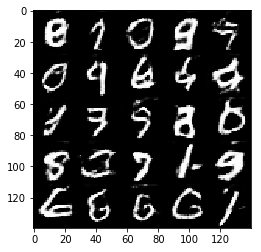

Step 1620... Epoch 1/1... Discriminator Loss: 1.0546... Generator Loss: 0.6991
Step 1640... Epoch 1/1... Discriminator Loss: 1.0591... Generator Loss: 0.6363
Step 1660... Epoch 1/1... Discriminator Loss: 0.8296... Generator Loss: 0.8195
Step 1680... Epoch 1/1... Discriminator Loss: 1.1370... Generator Loss: 0.5520
Step 1700... Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.7131
Step 1720... Epoch 1/1... Discriminator Loss: 0.8386... Generator Loss: 2.3731
Step 1740... Epoch 1/1... Discriminator Loss: 0.9802... Generator Loss: 0.6818
Step 1760... Epoch 1/1... Discriminator Loss: 0.6745... Generator Loss: 1.0903
Step 1780... Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.3640
Step 1800... Epoch 1/1... Discriminator Loss: 0.5873... Generator Loss: 1.3978


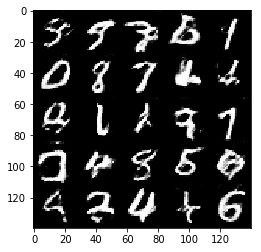

Step 1820... Epoch 1/1... Discriminator Loss: 1.4340... Generator Loss: 0.4199
Step 1840... Epoch 1/1... Discriminator Loss: 0.5479... Generator Loss: 1.8653
Step 1860... Epoch 1/1... Discriminator Loss: 1.1659... Generator Loss: 0.5860
Step 1880... Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 1.2904
Step 1900... Epoch 1/1... Discriminator Loss: 0.9470... Generator Loss: 1.1187
Step 1920... Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 0.8630
Step 1940... Epoch 1/1... Discriminator Loss: 1.8988... Generator Loss: 0.2093
Step 1960... Epoch 1/1... Discriminator Loss: 2.1523... Generator Loss: 0.1744
Step 1980... Epoch 1/1... Discriminator Loss: 0.5544... Generator Loss: 1.1644
Step 2000... Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.6148


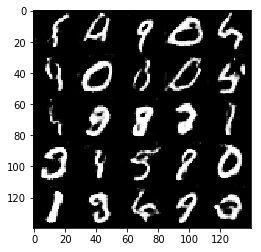

Step 2020... Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.3894
Step 2040... Epoch 1/1... Discriminator Loss: 0.8116... Generator Loss: 1.0707
Step 2060... Epoch 1/1... Discriminator Loss: 1.2535... Generator Loss: 0.5326
Step 2080... Epoch 1/1... Discriminator Loss: 0.9856... Generator Loss: 0.7895
Step 2100... Epoch 1/1... Discriminator Loss: 0.5948... Generator Loss: 1.2607
Step 2120... Epoch 1/1... Discriminator Loss: 1.2109... Generator Loss: 0.4829
Step 2140... Epoch 1/1... Discriminator Loss: 1.5981... Generator Loss: 0.3208
Step 2160... Epoch 1/1... Discriminator Loss: 1.0740... Generator Loss: 0.6764
Step 2180... Epoch 1/1... Discriminator Loss: 1.1380... Generator Loss: 0.5178
Step 2200... Epoch 1/1... Discriminator Loss: 0.4550... Generator Loss: 1.4623


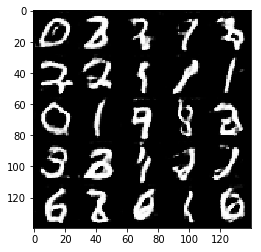

Step 2220... Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 0.9645
Step 2240... Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.4621
Step 2260... Epoch 1/1... Discriminator Loss: 1.0218... Generator Loss: 0.7541
Step 2280... Epoch 1/1... Discriminator Loss: 0.7948... Generator Loss: 0.8229
Step 2300... Epoch 1/1... Discriminator Loss: 0.7513... Generator Loss: 0.8586
Step 2320... Epoch 1/1... Discriminator Loss: 1.0684... Generator Loss: 0.8751
Step 2340... Epoch 1/1... Discriminator Loss: 1.0346... Generator Loss: 0.8424
Step 2360... Epoch 1/1... Discriminator Loss: 0.9628... Generator Loss: 0.6872
Step 2380... Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.6506
Step 2400... Epoch 1/1... Discriminator Loss: 0.5636... Generator Loss: 1.3380


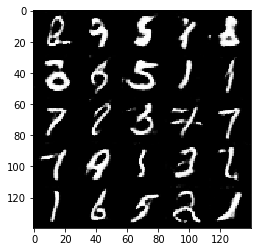

Step 2420... Epoch 1/1... Discriminator Loss: 0.3197... Generator Loss: 2.2537
Step 2440... Epoch 1/1... Discriminator Loss: 0.9460... Generator Loss: 0.6741
Step 2460... Epoch 1/1... Discriminator Loss: 2.1136... Generator Loss: 0.4627
Step 2480... Epoch 1/1... Discriminator Loss: 0.5503... Generator Loss: 1.3640
Step 2500... Epoch 1/1... Discriminator Loss: 2.1365... Generator Loss: 0.1763
Step 2520... Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 0.7559
Step 2540... Epoch 1/1... Discriminator Loss: 0.9048... Generator Loss: 0.8341
Step 2560... Epoch 1/1... Discriminator Loss: 0.6420... Generator Loss: 1.0976
Step 2580... Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.4203
Step 2600... Epoch 1/1... Discriminator Loss: 0.6988... Generator Loss: 1.1065


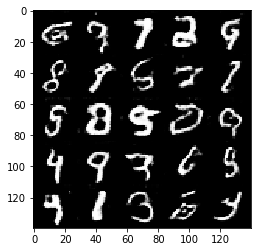

Step 2620... Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.6263
Step 2640... Epoch 1/1... Discriminator Loss: 0.6638... Generator Loss: 0.9940
Step 2660... Epoch 1/1... Discriminator Loss: 0.9155... Generator Loss: 0.7190
Step 2680... Epoch 1/1... Discriminator Loss: 0.8575... Generator Loss: 0.8189
Step 2700... Epoch 1/1... Discriminator Loss: 1.1705... Generator Loss: 0.5887
Step 2720... Epoch 1/1... Discriminator Loss: 0.9395... Generator Loss: 0.8234
Step 2740... Epoch 1/1... Discriminator Loss: 0.5775... Generator Loss: 1.0321
Step 2760... Epoch 1/1... Discriminator Loss: 1.3248... Generator Loss: 0.4625
Step 2780... Epoch 1/1... Discriminator Loss: 0.8153... Generator Loss: 0.9256
Step 2800... Epoch 1/1... Discriminator Loss: 1.3005... Generator Loss: 0.5513


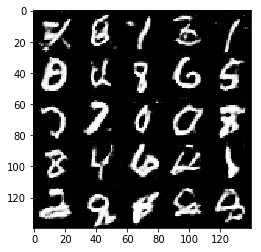

Step 2820... Epoch 1/1... Discriminator Loss: 0.5196... Generator Loss: 1.5711
Step 2840... Epoch 1/1... Discriminator Loss: 1.0543... Generator Loss: 0.6254
Step 2860... Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 1.0074
Step 2880... Epoch 1/1... Discriminator Loss: 1.1025... Generator Loss: 0.6217
Step 2900... Epoch 1/1... Discriminator Loss: 0.6686... Generator Loss: 1.3152
Step 2920... Epoch 1/1... Discriminator Loss: 1.9892... Generator Loss: 0.1894
Step 2940... Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.5673
Step 2960... Epoch 1/1... Discriminator Loss: 1.0388... Generator Loss: 0.5851
Step 2980... Epoch 1/1... Discriminator Loss: 0.4194... Generator Loss: 1.3546
Step 3000... Epoch 1/1... Discriminator Loss: 0.1894... Generator Loss: 2.5677


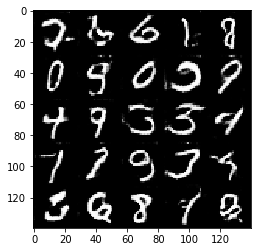

Step 3020... Epoch 1/1... Discriminator Loss: 0.8292... Generator Loss: 1.0571
Step 3040... Epoch 1/1... Discriminator Loss: 0.9900... Generator Loss: 0.8176
Step 3060... Epoch 1/1... Discriminator Loss: 0.9134... Generator Loss: 0.8061
Step 3080... Epoch 1/1... Discriminator Loss: 1.2415... Generator Loss: 0.5317
Step 3100... Epoch 1/1... Discriminator Loss: 0.4061... Generator Loss: 1.4391
Step 3120... Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.4064
Step 3140... Epoch 1/1... Discriminator Loss: 1.5717... Generator Loss: 0.4686
Step 3160... Epoch 1/1... Discriminator Loss: 1.2544... Generator Loss: 0.4603
Step 3180... Epoch 1/1... Discriminator Loss: 0.5747... Generator Loss: 1.0754
Step 3200... Epoch 1/1... Discriminator Loss: 0.6485... Generator Loss: 1.3326


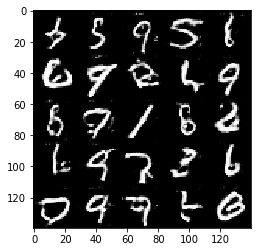

Step 3220... Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.3586
Step 3240... Epoch 1/1... Discriminator Loss: 1.1565... Generator Loss: 0.6493
Step 3260... Epoch 1/1... Discriminator Loss: 0.4249... Generator Loss: 1.4717
Step 3280... Epoch 1/1... Discriminator Loss: 0.6536... Generator Loss: 1.1931
Step 3300... Epoch 1/1... Discriminator Loss: 0.7469... Generator Loss: 1.1767
Step 3320... Epoch 1/1... Discriminator Loss: 1.2946... Generator Loss: 0.4663
Step 3340... Epoch 1/1... Discriminator Loss: 1.7033... Generator Loss: 0.5451
Step 3360... Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.5291
Step 3380... Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 0.6894
Step 3400... Epoch 1/1... Discriminator Loss: 0.3871... Generator Loss: 1.7256


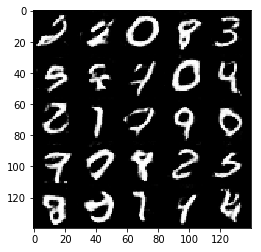

Step 3420... Epoch 1/1... Discriminator Loss: 0.5466... Generator Loss: 1.5989
Step 3440... Epoch 1/1... Discriminator Loss: 0.8402... Generator Loss: 0.7869
Step 3460... Epoch 1/1... Discriminator Loss: 0.6333... Generator Loss: 1.1850
Step 3480... Epoch 1/1... Discriminator Loss: 1.3011... Generator Loss: 0.4369
Step 3500... Epoch 1/1... Discriminator Loss: 0.6458... Generator Loss: 1.0791
Step 3520... Epoch 1/1... Discriminator Loss: 0.3692... Generator Loss: 1.4264
Step 3540... Epoch 1/1... Discriminator Loss: 0.8114... Generator Loss: 0.9568
Step 3560... Epoch 1/1... Discriminator Loss: 0.5514... Generator Loss: 1.2863
Step 3580... Epoch 1/1... Discriminator Loss: 0.5979... Generator Loss: 1.0671
Step 3600... Epoch 1/1... Discriminator Loss: 1.8315... Generator Loss: 0.3406


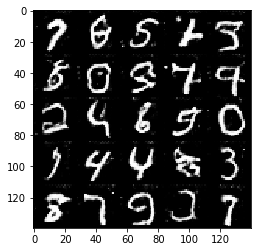

Step 3620... Epoch 1/1... Discriminator Loss: 1.5017... Generator Loss: 0.2836
Step 3640... Epoch 1/1... Discriminator Loss: 1.9463... Generator Loss: 0.2320
Step 3660... Epoch 1/1... Discriminator Loss: 0.3647... Generator Loss: 1.9156
Step 3680... Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 0.9077
Step 3700... Epoch 1/1... Discriminator Loss: 1.1621... Generator Loss: 0.7564
Step 3720... Epoch 1/1... Discriminator Loss: 0.6089... Generator Loss: 1.1720
Step 3740... Epoch 1/1... Discriminator Loss: 0.9940... Generator Loss: 0.8418
Step 3760... Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 0.7317
Step 3780... Epoch 1/1... Discriminator Loss: 0.4944... Generator Loss: 1.1061
Step 3800... Epoch 1/1... Discriminator Loss: 0.4680... Generator Loss: 1.7585


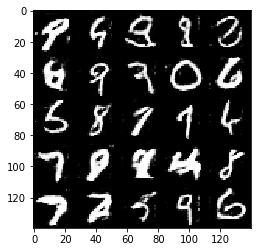

Step 3820... Epoch 1/1... Discriminator Loss: 1.1075... Generator Loss: 0.5239
Step 3840... Epoch 1/1... Discriminator Loss: 0.6758... Generator Loss: 1.2722
Step 3860... Epoch 1/1... Discriminator Loss: 0.5123... Generator Loss: 1.5656
Step 3880... Epoch 1/1... Discriminator Loss: 0.5467... Generator Loss: 1.3114
Step 3900... Epoch 1/1... Discriminator Loss: 0.5355... Generator Loss: 1.3865
Step 3920... Epoch 1/1... Discriminator Loss: 0.9417... Generator Loss: 0.8719
Step 3940... Epoch 1/1... Discriminator Loss: 1.2317... Generator Loss: 0.4153
Step 3960... Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 0.6341
Step 3980... Epoch 1/1... Discriminator Loss: 0.6379... Generator Loss: 1.0583
Step 4000... Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.6696


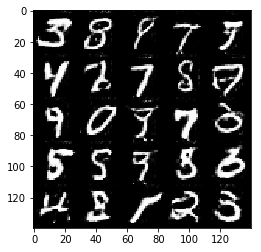

Step 4020... Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7017
Step 4040... Epoch 1/1... Discriminator Loss: 0.4252... Generator Loss: 1.6409
Step 4060... Epoch 1/1... Discriminator Loss: 0.6554... Generator Loss: 1.0728
Step 4080... Epoch 1/1... Discriminator Loss: 0.4969... Generator Loss: 1.3407
Step 4100... Epoch 1/1... Discriminator Loss: 0.9237... Generator Loss: 0.8319
Step 4120... Epoch 1/1... Discriminator Loss: 1.6175... Generator Loss: 0.2966
Step 4140... Epoch 1/1... Discriminator Loss: 0.4275... Generator Loss: 1.6607
Step 4160... Epoch 1/1... Discriminator Loss: 1.5372... Generator Loss: 0.4904
Step 4180... Epoch 1/1... Discriminator Loss: 0.9893... Generator Loss: 0.7391
Step 4200... Epoch 1/1... Discriminator Loss: 0.7124... Generator Loss: 1.1967


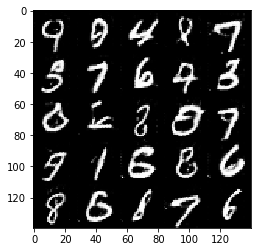

Step 4220... Epoch 1/1... Discriminator Loss: 1.1777... Generator Loss: 0.6620
Step 4240... Epoch 1/1... Discriminator Loss: 1.9428... Generator Loss: 0.1861
Step 4260... Epoch 1/1... Discriminator Loss: 1.6670... Generator Loss: 0.3411
Step 4280... Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.4743
Step 4300... Epoch 1/1... Discriminator Loss: 1.0020... Generator Loss: 0.6612
Step 4320... Epoch 1/1... Discriminator Loss: 0.8069... Generator Loss: 0.8723
Step 4340... Epoch 1/1... Discriminator Loss: 0.6593... Generator Loss: 1.0042
Step 4360... Epoch 1/1... Discriminator Loss: 0.6369... Generator Loss: 1.4430
Step 4380... Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.3877
Step 4400... Epoch 1/1... Discriminator Loss: 0.8035... Generator Loss: 0.9893


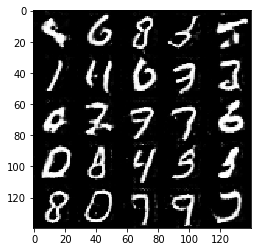

Step 4420... Epoch 1/1... Discriminator Loss: 0.7510... Generator Loss: 0.7995
Step 4440... Epoch 1/1... Discriminator Loss: 1.5839... Generator Loss: 0.3775
Step 4460... Epoch 1/1... Discriminator Loss: 0.1890... Generator Loss: 2.4111
Step 4480... Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.5536
Step 4500... Epoch 1/1... Discriminator Loss: 0.6788... Generator Loss: 0.9260
Step 4520... Epoch 1/1... Discriminator Loss: 1.3993... Generator Loss: 0.7066
Step 4540... Epoch 1/1... Discriminator Loss: 0.7938... Generator Loss: 0.8461
Step 4560... Epoch 1/1... Discriminator Loss: 0.8822... Generator Loss: 0.7741
Step 4580... Epoch 1/1... Discriminator Loss: 1.2990... Generator Loss: 0.5810
Step 4600... Epoch 1/1... Discriminator Loss: 0.4204... Generator Loss: 2.5617


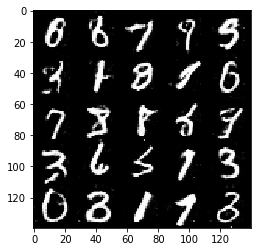

Step 4620... Epoch 1/1... Discriminator Loss: 0.6817... Generator Loss: 1.1757
Step 4640... Epoch 1/1... Discriminator Loss: 1.0164... Generator Loss: 0.5635
Step 4660... Epoch 1/1... Discriminator Loss: 0.9010... Generator Loss: 0.8541
Step 4680... Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6108
Step 4700... Epoch 1/1... Discriminator Loss: 2.5430... Generator Loss: 0.1124
Step 4720... Epoch 1/1... Discriminator Loss: 0.8064... Generator Loss: 0.6928
Step 4740... Epoch 1/1... Discriminator Loss: 0.3312... Generator Loss: 1.5533
Step 4760... Epoch 1/1... Discriminator Loss: 0.3857... Generator Loss: 1.4431
Step 4780... Epoch 1/1... Discriminator Loss: 0.5844... Generator Loss: 1.9751
Step 4800... Epoch 1/1... Discriminator Loss: 0.2946... Generator Loss: 2.4056


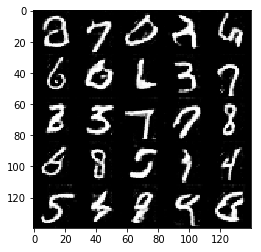

Step 4820... Epoch 1/1... Discriminator Loss: 1.7174... Generator Loss: 0.2709
Step 4840... Epoch 1/1... Discriminator Loss: 0.4760... Generator Loss: 1.8520
Step 4860... Epoch 1/1... Discriminator Loss: 0.4081... Generator Loss: 1.5832
Step 4880... Epoch 1/1... Discriminator Loss: 1.4206... Generator Loss: 0.4308
Step 4900... Epoch 1/1... Discriminator Loss: 0.4248... Generator Loss: 1.7015
Step 4920... Epoch 1/1... Discriminator Loss: 0.3543... Generator Loss: 2.4970
Step 4940... Epoch 1/1... Discriminator Loss: 0.7742... Generator Loss: 1.1096
Step 4960... Epoch 1/1... Discriminator Loss: 0.3458... Generator Loss: 1.9166
Step 4980... Epoch 1/1... Discriminator Loss: 0.8444... Generator Loss: 1.0807
Step 5000... Epoch 1/1... Discriminator Loss: 2.2664... Generator Loss: 0.1302


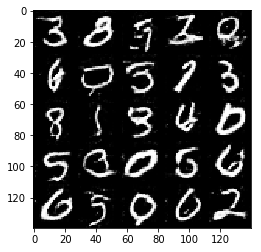

Step 5020... Epoch 1/1... Discriminator Loss: 0.7164... Generator Loss: 0.8488
Step 5040... Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.7904
Step 5060... Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.4324
Step 5080... Epoch 1/1... Discriminator Loss: 0.3025... Generator Loss: 1.7772
Step 5100... Epoch 1/1... Discriminator Loss: 0.6027... Generator Loss: 1.0773
Step 5120... Epoch 1/1... Discriminator Loss: 0.3073... Generator Loss: 1.8505
Step 5140... Epoch 1/1... Discriminator Loss: 2.0913... Generator Loss: 0.2423
Step 5160... Epoch 1/1... Discriminator Loss: 0.4673... Generator Loss: 2.3696
Step 5180... Epoch 1/1... Discriminator Loss: 0.5536... Generator Loss: 1.1926
Step 5200... Epoch 1/1... Discriminator Loss: 0.9022... Generator Loss: 0.7797


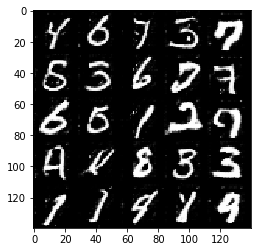

Step 5220... Epoch 1/1... Discriminator Loss: 1.1207... Generator Loss: 0.7278
Step 5240... Epoch 1/1... Discriminator Loss: 0.9045... Generator Loss: 0.7479
Step 5260... Epoch 1/1... Discriminator Loss: 0.3983... Generator Loss: 1.4851
Step 5280... Epoch 1/1... Discriminator Loss: 0.7749... Generator Loss: 1.0518
Step 5300... Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 1.1482
Step 5320... Epoch 1/1... Discriminator Loss: 0.6122... Generator Loss: 1.1701
Step 5340... Epoch 1/1... Discriminator Loss: 1.3900... Generator Loss: 0.4551
Step 5360... Epoch 1/1... Discriminator Loss: 0.6159... Generator Loss: 1.1753
Step 5380... Epoch 1/1... Discriminator Loss: 0.8531... Generator Loss: 0.8230
Step 5400... Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.7997


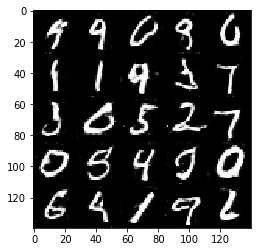

Step 5420... Epoch 1/1... Discriminator Loss: 2.2229... Generator Loss: 0.2688
Step 5440... Epoch 1/1... Discriminator Loss: 0.6979... Generator Loss: 1.0106
Step 5460... Epoch 1/1... Discriminator Loss: 0.5474... Generator Loss: 1.0828
Step 5480... Epoch 1/1... Discriminator Loss: 0.7355... Generator Loss: 1.1244
Step 5500... Epoch 1/1... Discriminator Loss: 0.9707... Generator Loss: 0.6167
Step 5520... Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 1.7108
Step 5540... Epoch 1/1... Discriminator Loss: 1.0217... Generator Loss: 0.5839
Step 5560... Epoch 1/1... Discriminator Loss: 1.1329... Generator Loss: 0.5226
Step 5580... Epoch 1/1... Discriminator Loss: 0.3937... Generator Loss: 2.0301
Step 5600... Epoch 1/1... Discriminator Loss: 1.3823... Generator Loss: 0.4044


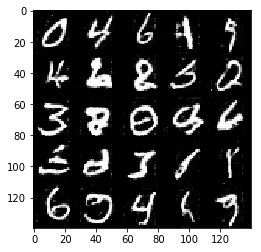

Step 5620... Epoch 1/1... Discriminator Loss: 0.4129... Generator Loss: 1.5285
Step 5640... Epoch 1/1... Discriminator Loss: 0.5185... Generator Loss: 1.3188
Step 5660... Epoch 1/1... Discriminator Loss: 2.0297... Generator Loss: 0.1823
Step 5680... Epoch 1/1... Discriminator Loss: 1.0666... Generator Loss: 0.7739
Step 5700... Epoch 1/1... Discriminator Loss: 0.8469... Generator Loss: 0.9882
Step 5720... Epoch 1/1... Discriminator Loss: 0.4261... Generator Loss: 1.3543
Step 5740... Epoch 1/1... Discriminator Loss: 0.8597... Generator Loss: 1.0094
Step 5760... Epoch 1/1... Discriminator Loss: 0.6664... Generator Loss: 1.1372
Step 5780... Epoch 1/1... Discriminator Loss: 0.5640... Generator Loss: 1.4045
Step 5800... Epoch 1/1... Discriminator Loss: 0.3770... Generator Loss: 1.5206


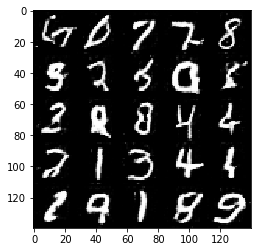

Step 5820... Epoch 1/1... Discriminator Loss: 0.8579... Generator Loss: 1.0751
Step 5840... Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.3553
Step 5860... Epoch 1/1... Discriminator Loss: 1.9352... Generator Loss: 0.2275
Step 5880... Epoch 1/1... Discriminator Loss: 0.6954... Generator Loss: 0.8197
Step 5900... Epoch 1/1... Discriminator Loss: 0.5559... Generator Loss: 1.4187
Step 5920... Epoch 1/1... Discriminator Loss: 0.5284... Generator Loss: 1.4869
Step 5940... Epoch 1/1... Discriminator Loss: 0.6456... Generator Loss: 1.2033
Step 5960... Epoch 1/1... Discriminator Loss: 0.7544... Generator Loss: 1.0351
Step 5980... Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 5.1688
Step 6000... Epoch 1/1... Discriminator Loss: 0.2402... Generator Loss: 2.3679


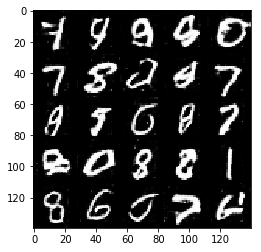

IndexError: list index out of range

In [12]:
batch_size = 10
z_dim = 100
z_size = 100
epochs = 1
alpha = 0.01
beta1 = 0.5
learning_rate = 0.0005

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
print("Number of images & shape of images:")
print(mnist_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode, alpha)

In [ ]:
batch_size = 10
z_dim = 100
z_size = 100
epochs = 1
alpha = 0.01
beta1 = 0.5
learning_rate = 0.0005



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
print("Number of images & shape of images:")
print(celeba_dataset.shape)
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.